In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt

import eqtk

Two component receptor models

In [2]:
#L, R1, P, F

N2c=[[-1, -1, 1, 0],
     [0, -1, -1, 1]]


#L1, L2, R, P1, P2, F1, F2

N2c2l=[[-1, 0, -1, 1, 0, 0, 0],
       [0, -1, -1, 0, 1, 0, 0],
       [0, 0, -1, -1, 0, 1, 0],
       [0, 0, -1, 0, -1, 0, 1]]

Fixed inhibitor change ligand parameters

In [3]:
#no inhibitor
# 
step = 0.001
size=30

S=np.zeros((size,size))
F=np.zeros((size,size))
A=np.zeros((size,7,size))

r = 1
l1 = np.logspace(-3, 3, size)
l2 = 0.0000001


#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size, 7))
c0[:,2] = r

fixed_c = -np.ones((size, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

for i,curk in enumerate(np.logspace(-3, 3, size)):
    K = [1,1,curk,100]

    c0[:,2] = r
    res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
    c0[:,2] = r+step/2
    res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
    c0[:,2] = r-step/2
    res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

    F[:,i]=res[:,5]
    S[:,i]=(res_p-res_m)/step/res[:,5]*r
    A[:,:,i]=res

    I = F.flatten().argsort()
    Fzero=F.flatten()[I]
    Szero=S.flatten()[I]


In [4]:
# add inhibitor
step = 0.001
size=15

S=np.zeros((size,size))
F=np.zeros((size,size))
A=np.zeros((size,7,size))

r = 1
l1 = np.logspace(0, 2.5, size)
l2 = 1


#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size, 7))
c0[:,2] = r

fixed_c = -np.ones((size, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

for i,curk in enumerate(np.logspace(-0.5, 3.5, size)):
    K = [1,1,curk,100]

    c0[:,2] = r
    res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
    c0[:,2] = r+step/2
    res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
    c0[:,2] = r-step/2
    res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

    F[:,i]=res[:,5]
    S[:,i]=(res_p-res_m)/step/res[:,5]*r
    A[:,:,i]=res



meta NOT subset; don't know how to subset; dropped


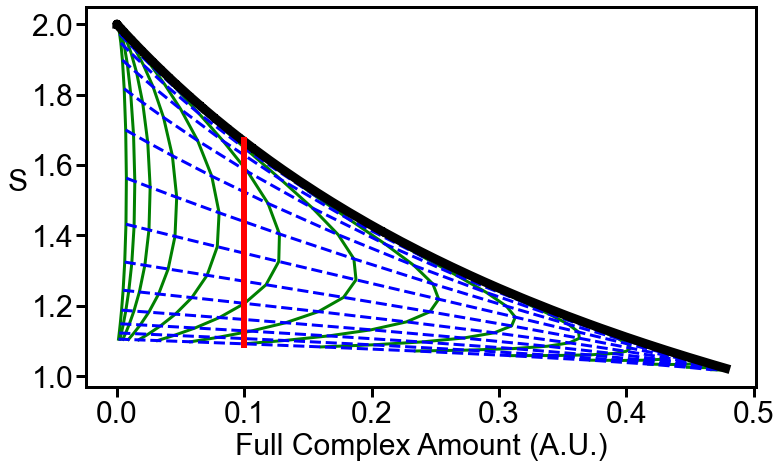

In [5]:
plt.figure(figsize=(12,7))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Full Complex Amount (A.U.)', fontsize=30)
plt.ylabel('S', fontsize=30, rotation=0, ha='right')



plt.plot(F,S,'-g', linewidth=3);
plt.plot(F.T,S.T,'--b', linewidth=3);

plt.plot(Fzero, Szero,'-k', linewidth=9);

plt.axvline(0.1, ymin=0.11, ymax = 0.65, c='r', linewidth='6')
plt.savefig('delme.pdf')


In [6]:
#find the k for each ligand that gives F=0.1
r = 1
l1 = np.logspace(0, 2.5, size)
l2 = 1


def error(curk,i):
    #L1, L2, R, P1, P2, F1, F2
    c0 = [0,0,r,0,0,0,0]

    fixed_c = [l1[i], l2, -1,-1,-1,-1,-1]

    K = [1,1,curk,100]

    return (eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[5]-0.1)**2

ks = []
for i in range(size):
    ks.append(opt.minimize(error, 1, i).x)

ks = np.concatenate(ks)

ks

array([31.37896427, 21.77114624, 15.25477708, 11.10001524,  8.4458163 ,
        6.79737073,  5.99513897,  5.91295026,  6.56953429,  8.13747114,
       10.86566761, 15.5105692 , 22.35824198, 32.49906287, 49.07212727])

In [7]:
#calculate CV
# 
ncell=10000
r = np.random.gamma(4, 0.25, ncell)
res=np.zeros([size,ncell])

for i in range(size):

    c0 = np.zeros((ncell, 7))
    c0[:,2] = r

    fixed_c = [l1[i], l2, -1, -1, -1, -1, -1]

    K = [1,1,ks[i],100]

    res[i,:] = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

res.std(axis=1)/res.mean(axis=1)

array([0.54468452, 0.5518074 , 0.56238655, 0.57768566, 0.59936678,
       0.62899012, 0.66648057, 0.70886923, 0.74965254, 0.78175909,
       0.80302414, 0.8136627 , 0.8203774 , 0.82484924, 0.82493553])

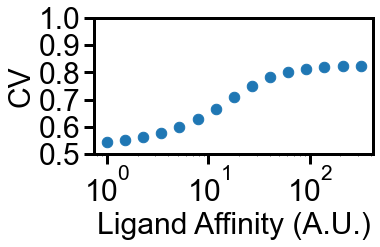

In [9]:
plt.figure(figsize=(5,2.5))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Ligand Affinity (A.U.)', fontsize=30)
plt.ylabel('CV', fontsize=30)

plt.ylim([0.5, 1])
plt.xscale('log')

plt.plot(l1, res.std(axis=1)/res.mean(axis=1),'.',markersize=21)


#plt.savefig('delme.pdf')


Fixed ligand change inhibitor parameters

In [10]:
step = 0.0001
size = 15

S=np.zeros((size,size))
F=np.zeros((size,size))
A=np.zeros((size,7,size))

r = 1
l1 = np.logspace(-3, 0, size)
l2 = np.logspace(-4, 0, size)

l1 = np.repeat(np.reshape(l1,[size,1]),size,1).reshape(-1)
l2 = np.repeat(np.reshape(l2,[1,size]),size,0).reshape(-1)

#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size**2, 7))
c0[:,2] = r

fixed_c = -np.ones((size**2, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

K = [1,1,10,100]

c0[:,2] = r
res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
c0[:,2] = r+step/2
res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
c0[:,2] = r-step/2
res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

F=res[:,5].reshape(size,size)
S=((res_p-res_m)/step/res[:,5]*r).reshape(size,size)
A=res.reshape(size,size,7)



meta NOT subset; don't know how to subset; dropped


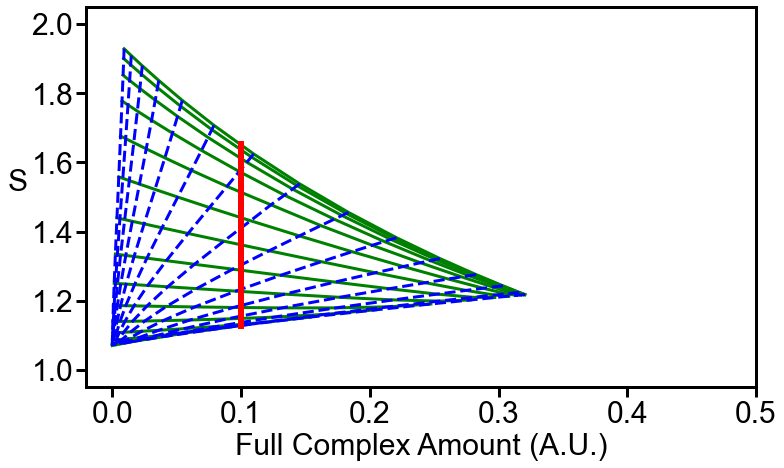

In [11]:
plt.figure(figsize=(12,7))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Full Complex Amount (A.U.)', fontsize=30)
plt.ylabel('S', fontsize=30, rotation=0, ha='right')

plt.xlim([-0.02, 0.5])
plt.ylim([0.95, 2.05])

plt.plot(F,S,'-g', linewidth=3);
plt.plot(F.T,S.T,'--b', linewidth=3);

#plt.plot(Fzero, Szero,'-k', linewidth=9);

plt.axvline(0.1, ymin=0.16, ymax = 0.64, c='r', linewidth='6')
plt.savefig('delme.pdf')



In [12]:
size=15
r = 1
l2 = np.logspace(-4.5, -0.545, size)

def error(curl, i):
    #L1, L2, R, P1, P2, F1, F2
    c0 = [0,0,r,0,0,0,0]

    fixed_c = [10**curl, l2[i], -1,-1,-1,-1,-1]

    K = [1,1,10,100]

    return (eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[5]-0.1)**2

ls = []
x0=0
for i in range(size):
    ls.append(10**(opt.minimize(error, 0, i, bounds=[(-3,1)]).x))
    x0=opt.minimize(error, 0, i).x

ls = np.concatenate(ls)

ls

array([0.01629957, 0.01644441, 0.01673212, 0.01727265, 0.01827952,
       0.02016819, 0.02360484, 0.02979261, 0.04082821, 0.0605222 ,
       0.0961393 , 0.1616847 , 0.28498866, 0.52304838, 0.99989795])

In [13]:
#calculate CV
# 
ncell=10000
r = np.random.gamma(4, 0.25, ncell)
res=np.zeros([size,ncell])

for i in range(size):

    c0 = np.zeros((ncell, 7))
    c0[:,2] = r

    fixed_c = [ls[i], l2[i], -1, -1, -1, -1, -1]

    K = [1,1,10,100]

    res[i,:] = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]


res.std(axis=1)/res.mean(axis=1)

array([0.83475457, 0.83211974, 0.82720277, 0.8184801 , 0.80385924,
       0.78128584, 0.75054897, 0.71416014, 0.67674353, 0.64270158,
       0.61467488, 0.5935996 , 0.57943301, 0.57190901, 0.57114116])

meta NOT subset; don't know how to subset; dropped


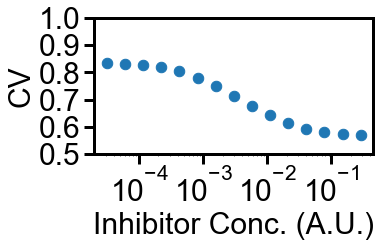

In [14]:
plt.figure(figsize=(5,2.5))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().tick_params(width=3, size=10)
for i in plt.gca().spines:
    plt.gca().spines[i].set_linewidth(3)

plt.xlabel('Inhibitor Conc. (A.U.)', fontsize=30)
plt.ylabel('CV', fontsize=30)

plt.ylim([0.5, 1])
plt.xscale('log')

plt.plot(l2, res.std(axis=1)/res.mean(axis=1),'.', markersize=21)


plt.savefig('delme.pdf')

In [ ]:
kjhg

array([0.09984617, 0.09980876, 0.09981048, 0.10012178, 0.10003224,
       0.10000624, 0.10030296, 0.10023305, 0.10000041, 0.10000071,
       0.1       , 0.09998337])

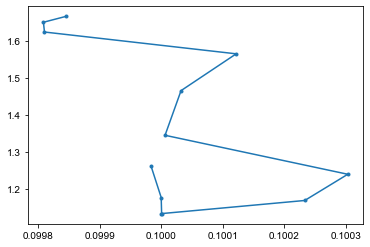

In [494]:
size=10

r = 1
l1 = [0.0166,0.0175,0.02,0.0262,0.04175,0.081,0.182,0.4569,1.2684,4]
l2 = np.logspace(-4, 0, size)
#l1 = 3.986*l2+0.016

size=12
l2 = np.concatenate([[0.000001],np.logspace(-4, 0, 10),[2]])
l1 = np.array([0.0161, 0.0166, 0.0175, 0.02, 0.0262, 0.04175, 0.081, 0.182, 0.4569, 1.2684, 4,10.4])


#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((size, 7))
c0[:,2] = r

fixed_c = -np.ones((size, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

K = [1,1,10,100]

c0[:,2] = r
res = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)
c0[:,2] = r+step/2
res_p = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]
c0[:,2] = r-step/2
res_m = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

F=res[:,5]
S=((res_p-res_m)/step/res[:,5]*r)
A=res

plt.plot(F,S,'.-')
F

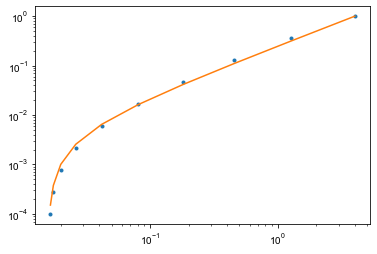

In [259]:
plt.plot(l1,l2,'.')
plt.xscale('log')
plt.yscale('log')
plt.plot(l1, (np.array(l1)-0.016)/3.986)

In [428]:
l1 = [0.0166,0.0175,0.02,0.0262,0.04175,0.081,0.182,0.4569,1.2684,4]
l2 = np.logspace(-4, 0, size)

print(F)
print(S)
print(l1)
print(l2)

[0.09980876 0.09981048 0.10012178 0.10003224 0.10000624 0.10030296
 0.10023305 0.10000041 0.10000071 0.1       ]
[1.65065102 1.62421857 1.565234   1.46565379 1.34480126 1.23936436
 1.1684157  1.13291565 1.13207061 1.17647059]
[0.0166, 0.0175, 0.02, 0.0262, 0.04175, 0.081, 0.182, 0.4569, 1.2684, 4]
[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]


In [ ]:
r~0.1

l1=0.02
l2=2.78255e-4

l1=0.8
l2=1


In [326]:
r.std()

4.900651649216541

In [536]:
r = np.random.gamma(4, 0.25, 10000)


In [537]:
l2 = np.concatenate([[0.000001],np.logspace(-4, 0, 10)])
l1 = np.array([0.01370, 0.01420, 0.01520, 0.01770, 0.02400, 0.04000,        0.07900, 0.18000, 0.45690, 1.26840, 4])


In [539]:
res=np.zeros([10,10000])

for i in range(10):

    c0 = np.zeros((10000, 7))
    c0[:,2] = r

    fixed_c = [l1[i], l2[i], -1, -1, -1, -1, -1]

    K = [1,1,10,100]


    res[i,:] = eqtk.fixed_value_solve(c0, fixed_c, N2c2l, K)[:,5]

In [540]:
print(res.mean(axis=1))
res.std(axis=1)/res.mean(axis=1)

[0.09932562 0.0991073  0.09929012 0.09922446 0.09913935 0.10003234
 0.10013868 0.10029875 0.1005256  0.10051831]


array([0.81915642, 0.80960003, 0.79399238, 0.76203711, 0.71141832,
       0.65357338, 0.60494729, 0.57224469, 0.55586749, 0.55547617])

In [550]:
0.82/0.555

1.4774774774774773

(0.5, 1.0)

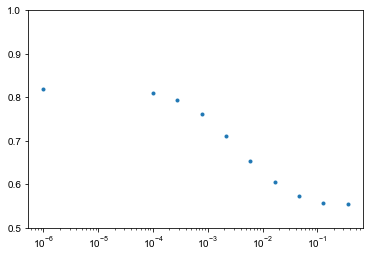

In [549]:
plt.plot(l2[:10],res.std(axis=1)/res.mean(axis=1),'.')
plt.xscale('log')
plt.ylim([0.5,1])

In [427]:
print(res9.mean())
res9.std()/res9.mean()

0.11118606878764063


0.8151562584419574

In [ ]:

0.30790604541825317
0.1711175606963472

0.5557460246157384


In [307]:



print(res9.mean())
print(res9.std())
print(res2.mean())
print(res2.std())

print(res2.std()/res2.mean())
print(res9.std()/res9.mean())

1.0190586153500851
0.600726101121742
1.0746143356603108
0.82304541269498
0.765898411535008
0.5894912148064907


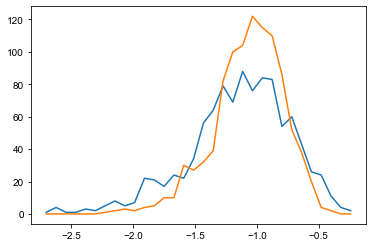

In [425]:
(h2,b) = np.histogram(np.log10(res), bins=32)
(h3,b) = np.histogram(np.log10(res9), bins=b)

plt.plot( (b[:-1]+b[1:])/2 , h2)
plt.plot( (b[:-1]+b[1:])/2 , h3)



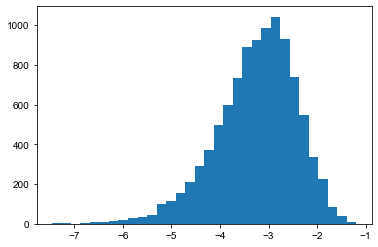

In [289]:
plt.hist(np.log(res), bins=32);

In [4]:
#L,R ->C

l=1
r=1

c0 = (l, r, 0)
fixed_c = (l, -1, -1)

N = [[-1, -1, 1]]

K = [1]

eqtk.fixed_value_solve(c0, fixed_c, N, K)


array([1. , 0.5, 0.5])

In [39]:
#np.random.seed(371)
r = np.random.gamma(4, 0.25, 10000)

r.mean(), r.std()

(0.9935847870544962, 0.5005009250350124)

In [ ]:
r = np.random.gamma(4, 0.25, 10000)
l=2

c0 = np.zeros((10000, 3))
c0[:,0] = l
c0[:,1] = r

fixed_c = (l, -1, -1)

eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,2]/r

array([0.66666667, 0.66666667, 0.66666668, ..., 0.66666667, 0.66666667,
       0.66666667])

Two component receptor

In [260]:
#np.random.seed(371)
r = np.random.gamma(4, 0.25, 10000)
l=1

#L, R1, P, F

c0 = np.zeros((10000, 4))
c0[:,1] = r

fixed_c = (l, -1, -1, -1)

N=[[-1, -1, 1, 0],
   [0, -1, -1, 1]]

K = [128, 30]


res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,3]
res.mean(), res.std(), res.std()/res.mean()


(0.14138310633051518, 0.11066572877203783, 0.7827365775464822)

In [ ]:
(0.1443840377829377, 0.11080504513606368, 0.7674327913078896)


In [ ]:
#L,R,P,F
c0 = (0,0.5850389,0,0)
fixed_c = (1, -1, -1, -1)
K=[1,1]

eqtk.fixed_value_solve(c0, fixed_c, N, K)*7.46


array([7.46      , 1.76473161, 1.76473161, 0.41746349])

In [186]:
0.0560*7.464

0.417984

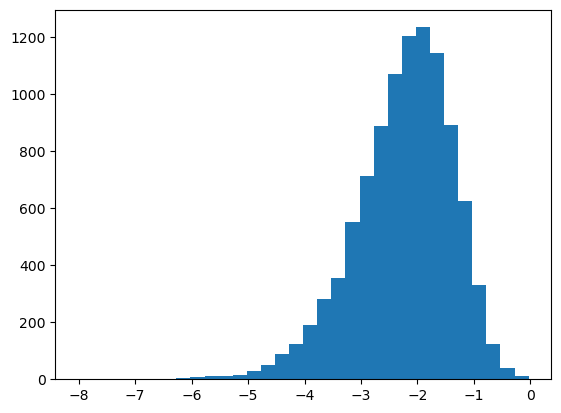

In [196]:
plt.hist(np.log(res), bins=32);

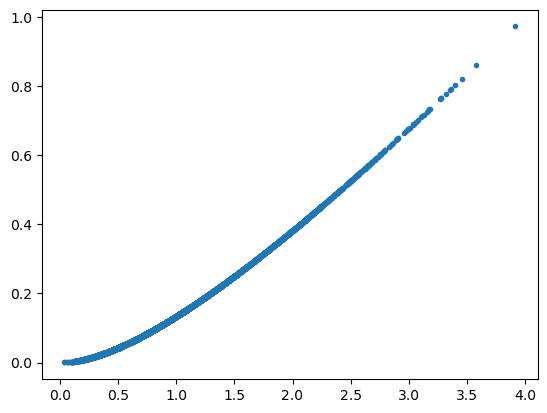

In [197]:
plt.plot(r, res,'.')

Two components two ligands

In [641]:
#np.random.seed(371)
r = np.random.gamma(4, 0.25, 10000)
l1=1
l2=1

#L1, L2, R, P1, P2, F1, F2

c0 = np.zeros((10000, 7))
c0[:,2] = r

fixed_c = (l1, l2, -1, -1, -1, -1, -1)

N=[[-1, 0, -1, 1, 0, 0, 0],
   [0, -1, -1, 0, 1, 0, 0],
   [0, 0, -1, -1, 0, 1, 0],
   [0, 0, -1, 0, -1, 0, 1]]

K = [0.0021,0.1,100,1]
K = [0.01,1,100,1]
K = [0.22,10,100,1]
K = [20,100,100,1]

K = [40,43,100,1]


res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
res.mean(), res.std(), res.std()/res.mean()


(0.21134908504567207, 0.14547058507302482, 0.6882953150310017)

In [645]:
K = [1,1,100,1]
fixed_c = (160, 0.000001, -1, -1, -1, -1, -1)

res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
print(res.mean(), res.std(), res.std()/res.mean())

0.219855920122715 0.15003806112637794 0.6824381214871655


In [ ]:
K = [43,40,100,1]


In [ ]:
K = [0.01,1,100,1]
res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
print(res.mean(), res.std(), res.std()/res.mean())

K = [20,100,100,1]
res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
print(res.mean(), res.std(), res.std()/res.mean())

K = [20,200,100,1]
res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
print(res.mean(), res.std(), res.std()/res.mean())



0.09937043750753449 0.07049703406490429 0.7094366879441287
0.0988841649074122 0.08170472681350281 0.8262670457904464
0.04050237758337221 0.03775677675130904 0.9322113664460443


In [ ]:
(0.07911949252537705, 0.06455313997511265, 0.8158942621428931) 10,20,10,1
(0.08033651167825855, 0.06969429700153904, 0.8675295397522269) 10,1,1.43,1





In [520]:
#L1, L2, R, P1, P2, F1, F2
c0 = (0,0,1,0,0,0,0)
fixed_c = (400, 200, -1, -1, -1, -1, -1)
K = [1,1,100,1]

eqtk.fixed_value_solve(c0, fixed_c, N, K)

array([4.00000000e+02, 2.00000000e+02, 1.40122970e-03, 5.60491881e-01,
       2.80245940e-01, 7.85377870e-02, 3.92688935e-04])

In [514]:
28+56+15

99

In [ ]:
#run over l1

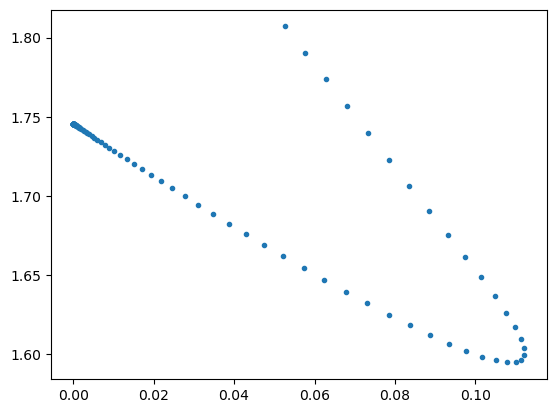

In [783]:
r = 1
l1 = np.logspace(-2, 4, 100)
l2 = 1000


#L1, L2, R, P1, P2, F1, F2
c0 = np.zeros((100, 7))
c0[:,2] = r

fixed_c = -np.ones((100, 7))
fixed_c[:,0] = l1
fixed_c[:,1] = l2

K = [1,1,800,100]

c0[:,2] = r
res = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
c0[:,2] = r+0.001
res_p = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]
c0[:,2] = r-0.001
res_m = eqtk.fixed_value_solve(c0, fixed_c, N, K)[:,5]

F=res
S=(res_p-res_m)/0.002/res

plt.plot(F,S,'.')

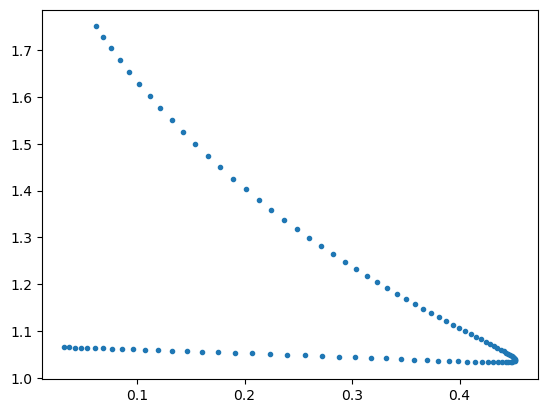

In [777]:
plt.plot(F,S,'.')

WilcoxonResult(statistic=0.0, pvalue=0.5)